# Description

Notebook for single covariate simulation results (Section 5).

# Imports

In [1]:
# to hide warnings for pretty notebook rendering in repo
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import multiprocessing
import numpy as np
import os
import pandas as pd
import pingouin as pg

import pickle
import seaborn as sns
import sklearn
import sys
from scipy.stats import fisher_exact, chi2_contingency
from tqdm import tqdm

# user imports
#sys.path.append("../src/rdd-discovery")
sys.path.append("../../")

from utils.sim import *
from utils.rddd import *
from utils.pwr import *

In [2]:
%matplotlib inline

In [3]:
#DATA_DIR = "../data/"
DATA_DIR = "../../results/tmlr_rebuttal/"
FIG_DIR = "../../figures/tmlr_rebuttal/"

# Figure 1: point plot

In [4]:
def point_plot(x, target, df, scale, ax, errwidth=0):
    """Visualizes the simulated data with a pointplot."""

    sns.pointplot(np.floor(df[x]*scale) / scale, df[target], join=False, errwidth=errwidth, ax=ax)
    #ax.set_xticks(np.arange(0,scale+1,scale/10), [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [5]:
seed = 42
n_samples = 1000
fuzzy_gap = 0.7

blended_df = generate_cont_blended_rdd(seed=seed, n=n_samples, fuzzy_gap=fuzzy_gap)

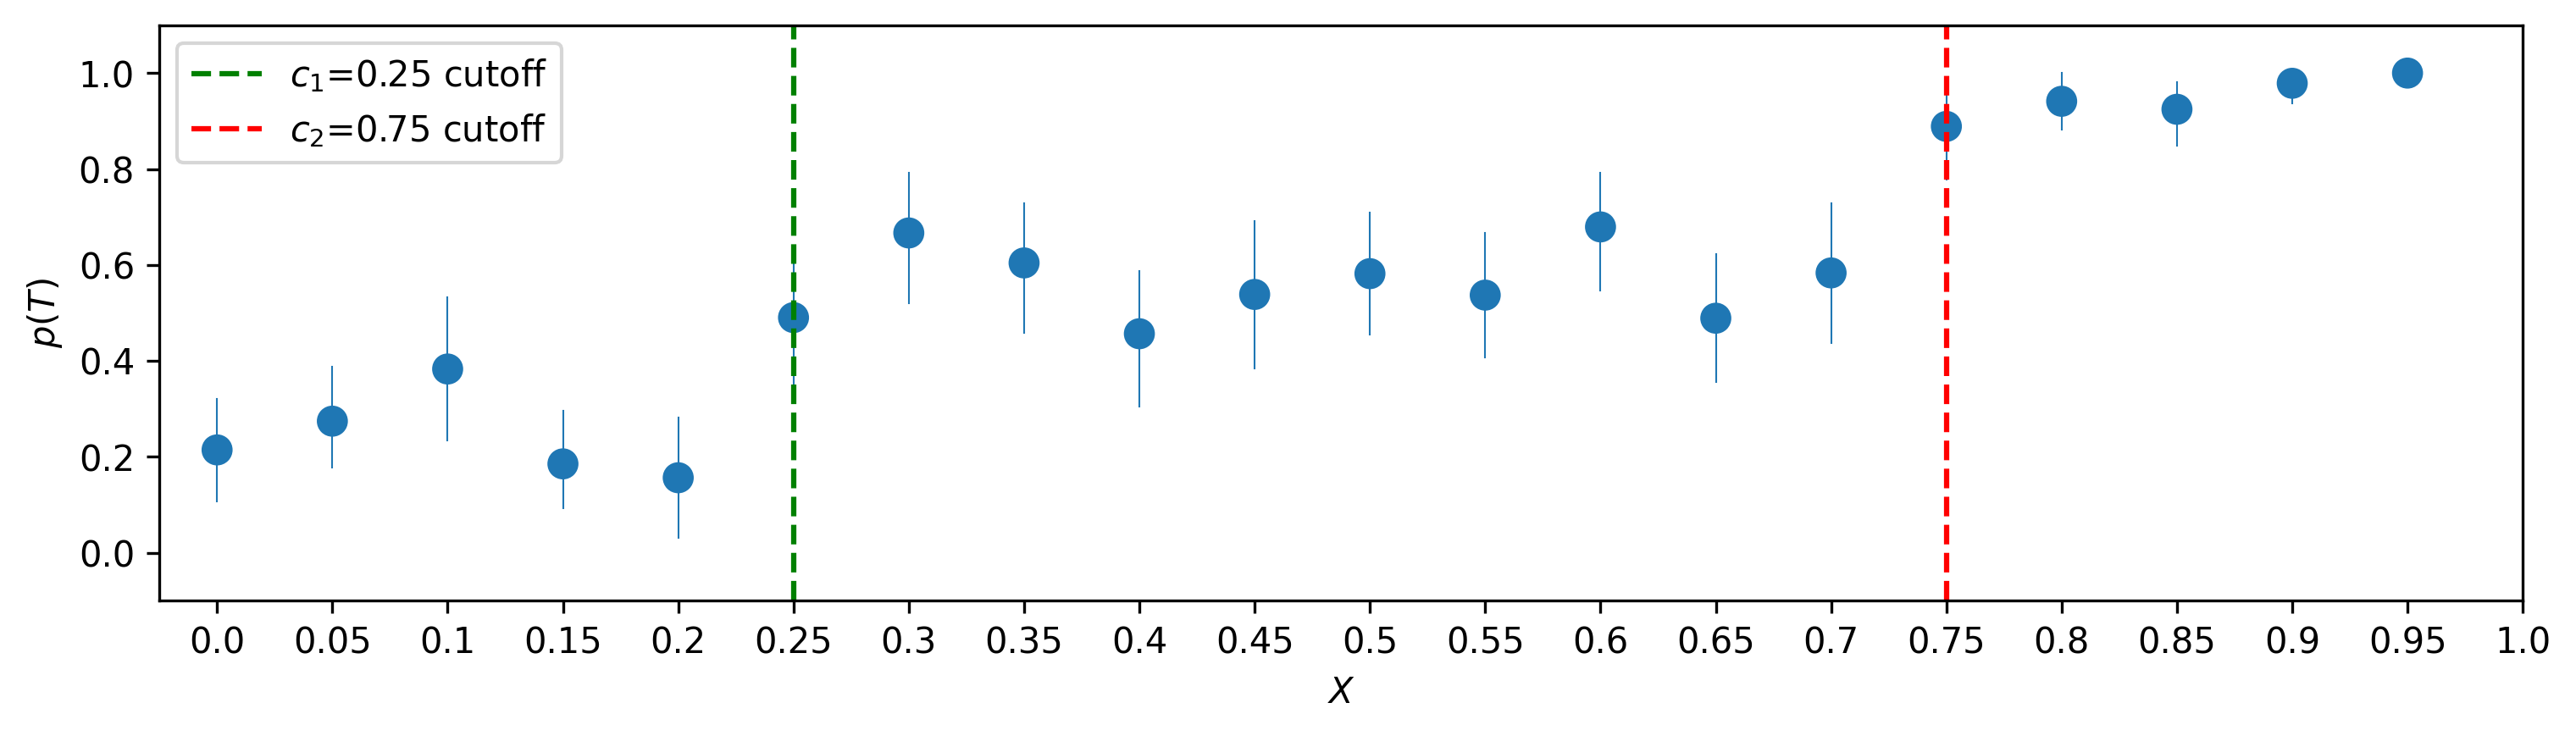

In [6]:
fig, ax = plt.subplots(dpi=300, figsize=(12,3))

scale = 20
fig.patch.set_facecolor('white')

point_plot(x='x', target='t', df=blended_df, scale=scale, ax=ax, errwidth=0.5)

ax.axvline(0.25*scale, ls='--', color='green', label="$c_1$=0.25 cutoff")
ax.axvline(0.75*scale, ls='--', color='red', label="$c_2$=0.75 cutoff")
#ax.set_xticks(np.arange(0,scale+1,scale/10), labels=[0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_xticks(np.arange(0,scale+1,scale/20), labels=np.round(np.arange(0, 1.01, 0.05), 2))
ax.legend()
ax.set_ylabel("$p(T)$")
ax.set_xlabel("$X$")
#ax.set_title("Scatter plot of treatment vs running (95% CI)")
#ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
plt.savefig(os.path.join(FIG_DIR, "fig1_pointplot.png"), bbox_inches="tight")

## Appendix Figure C.2: side by side plot

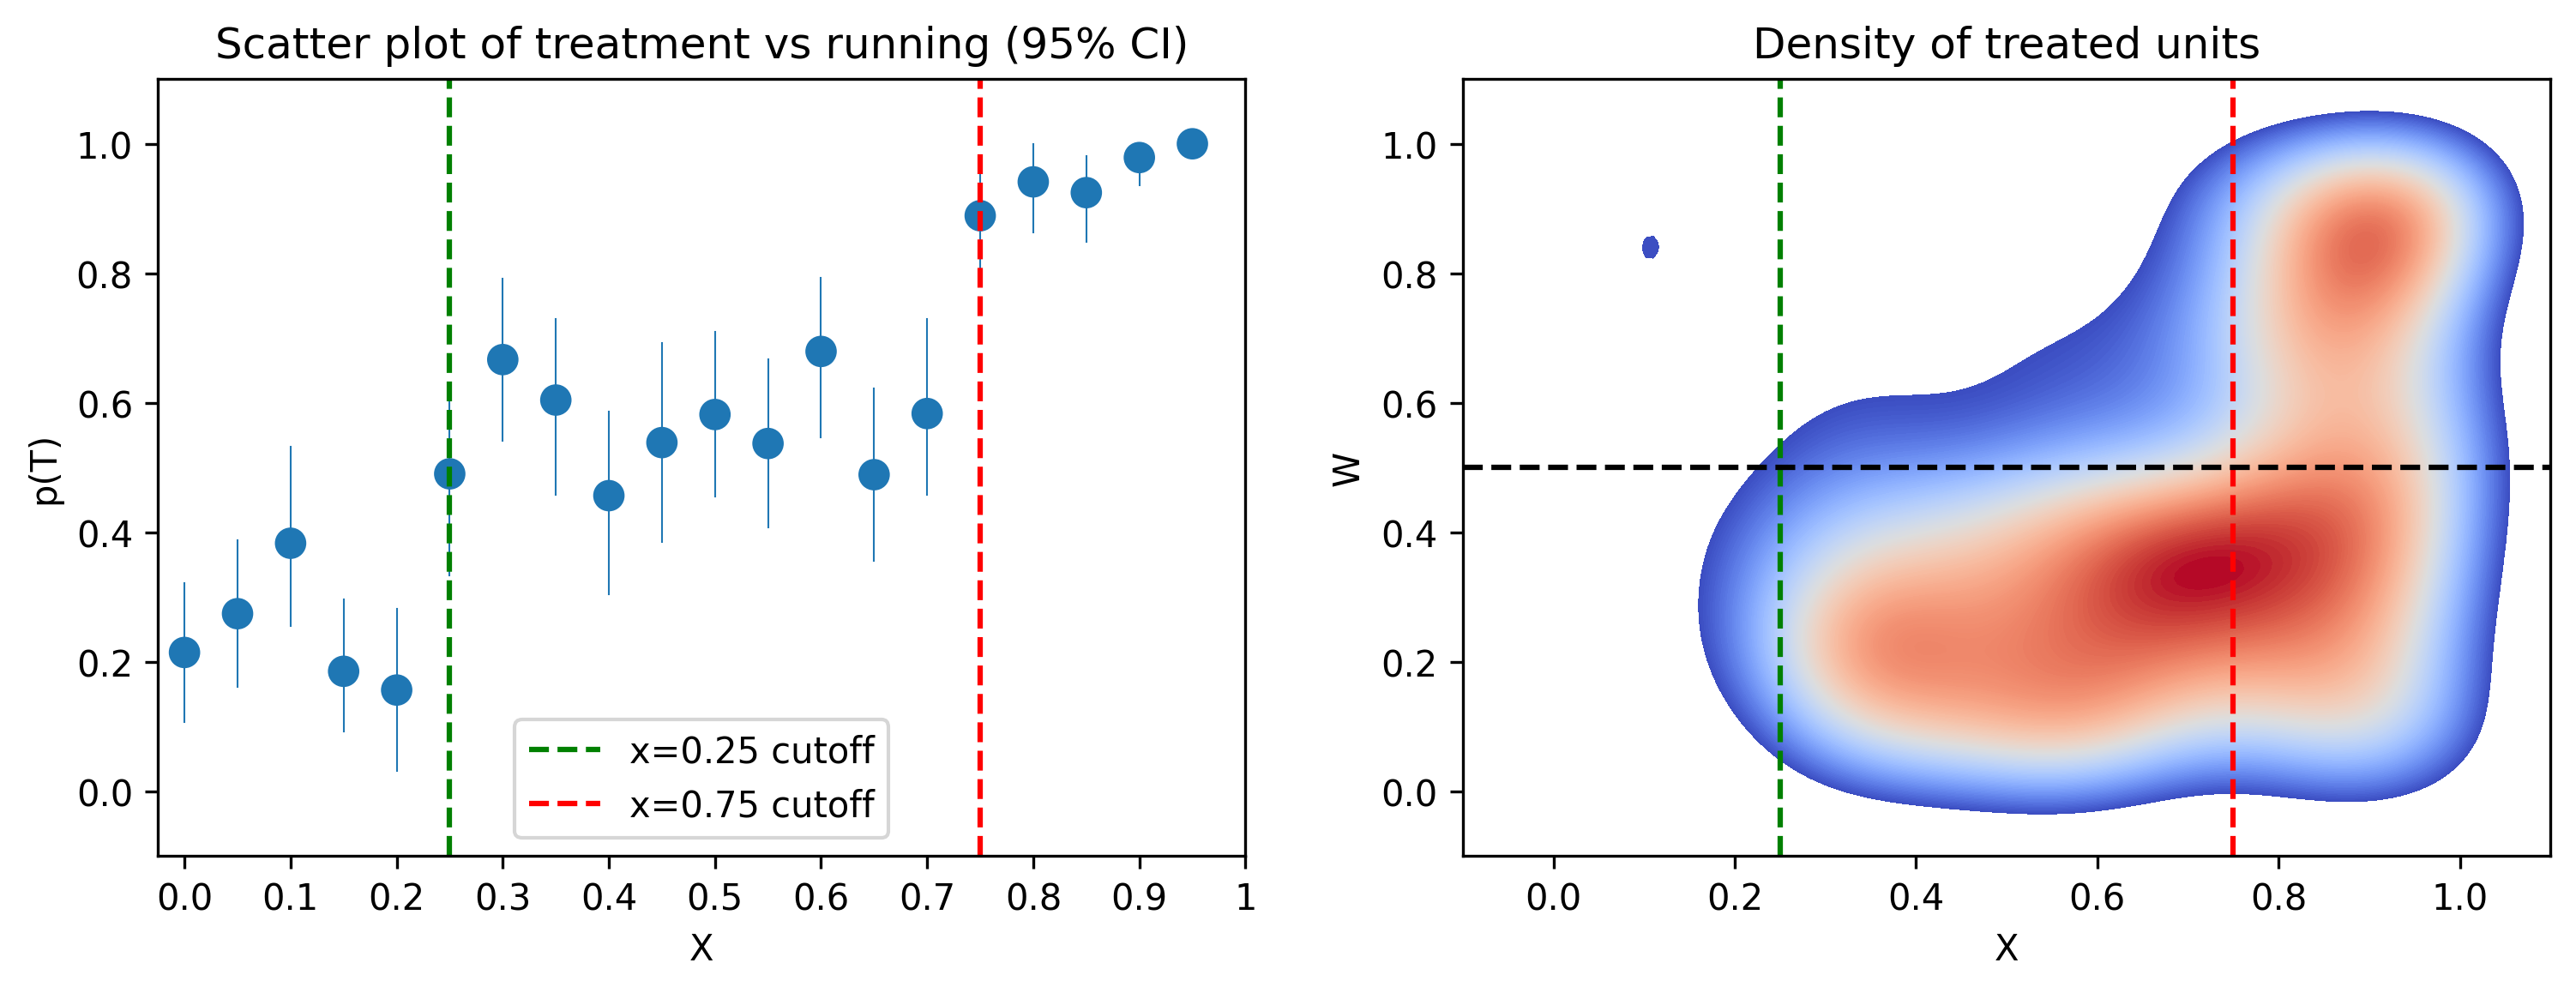

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300, figsize=(12,4))

scale = 20
#fig, ax1 = plt.subplots(dpi=100, figsize=(6,6))

point_plot(x='x', target='t', df=blended_df, scale=scale, ax=ax1, errwidth=0.5)

ax1.axvline(0.25*scale, ls='--', color='green', label="x=0.25 cutoff")
ax1.axvline(0.75*scale, ls='--', color='red', label="x=0.75 cutoff")
ax1.set_xticks(np.arange(0,scale+1,scale/10), labels=[0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax1.legend()
ax1.set_ylabel("p(T)")
ax1.set_xlabel("X")
ax1.set_title("Scatter plot of treatment vs running (95% CI)")
#ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)

treat_df = blended_df[blended_df['t'] == 1]

sns.kdeplot(treat_df['x'], treat_df['covar'],
            levels=150,  
            cmap='coolwarm',
            thresh=0.25,
            ax=ax2,
            fill=True
            #cbar=True,
            #common_norm=True)
           )
ax2.axvline(x=0.75, ls='--', color='red')
ax2.axvline(x=0.25, ls='--', color='green')
ax2.axhline(y=0.5, ls='--', color='black')
ax2.set_title("Density of treated units")
ax2.set_xlabel("X")
ax2.set_ylabel("W")
ax2.set_xlim(-0.1, 1.1)
ax2.set_ylim(-0.1, 1.1)
fig.savefig(os.path.join(FIG_DIR, "app_blended_rdd_scatter.png"), bbox='tight')

# Process simulated results

In [8]:
n_trials = 500
fuzzy_gaps = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]#, 0.8]
cutoffs = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

In [10]:
x_grid = np.arange(0.05, 0.96, 0.05)

## Power graphs

### oracle baseline power

In [11]:
alpha = 0.05 / len(x_grid)

lower_powers = []
upper_powers = []

lower_cutoff = 0.25
upper_cutoff = 0.75
take=0.05
const = 0.2
n_samples = 1000

for fuzzy_gap in fuzzy_gaps:
    u_ptake_lower = const + (take*upper_cutoff) + fuzzy_gap/2
    u_ptake_upper = const + (take*upper_cutoff) + fuzzy_gap
    
    l_ptake_lower = const + (take*lower_cutoff)
    l_ptake_upper = const + (take*lower_cutoff) + fuzzy_gap/2
    
    
    l_var = first_stage_asymp_var(l_ptake_lower, l_ptake_upper, n_samples, n_samples//2)
    u_var = first_stage_asymp_var(u_ptake_lower, u_ptake_upper, n_samples, n_samples//2)
    
    lower_powers.append(rdd_power(fuzzy_gap/2, var=l_var, alpha=alpha))
    upper_powers.append(rdd_power(fuzzy_gap/2, var=u_var, alpha=alpha))

### oracle max power

In [12]:
alpha = 0.05 / len(x_grid)

lower_max_powers = []
upper_max_powers = []


n_samples = 1000

for fuzzy_gap in fuzzy_gaps:
    u_ptake_lower = const + (take*upper_cutoff)
    u_ptake_upper = const + (take*upper_cutoff) + fuzzy_gap
    
    l_ptake_lower = const + (take*lower_cutoff)
    l_ptake_upper = const + (take*lower_cutoff) + fuzzy_gap
    
    
    l_var = first_stage_asymp_var(l_ptake_lower, l_ptake_upper, n_samples, n_samples//4)
    u_var = first_stage_asymp_var(u_ptake_lower, u_ptake_upper, n_samples, n_samples//4)
    
    lower_max_powers.append(rdd_power(fuzzy_gap, var=l_var, alpha=alpha))
    upper_max_powers.append(rdd_power(fuzzy_gap, var=u_var, alpha=alpha))

## Load data

In [14]:
first_stage_results = pickle.load(open(os.path.join(DATA_DIR, "blend_baseline_results.dict"), "rb"))
rdsgd_results = pickle.load(open(os.path.join(DATA_DIR, "rdsgd_neff_results_sample_split.dict"), "rb"))
herlands_results = pickle.load(open(os.path.join(DATA_DIR, "herlands_results.dict"), "rb"))

### baseline power

In [15]:
lower_emp_fs_pwr = [(n_trials - first_stage_results[gap]['x']['lower_fn']) / n_trials for gap in fuzzy_gaps]
upper_emp_fs_pwr = [(n_trials - first_stage_results[gap]['x']['upper_fn']) / n_trials for gap in fuzzy_gaps]

### subgroup power

In [16]:
lower_emp_pt_pwr = [rdsgd_results[gap]['lower_tp'] / n_trials for gap in fuzzy_gaps]
upper_emp_pt_pwr = [rdsgd_results[gap]['upper_tp'] / n_trials for gap in fuzzy_gaps]

### Herlands et al. power

In [17]:
lower_emp_herlands_pwr = [herlands_results[gap]['lower_tp'] / n_trials for gap in fuzzy_gaps]
upper_emp_herlands_pwr = [herlands_results[gap]['upper_tp'] / n_trials for gap in fuzzy_gaps]

# Figure 2: simulated power

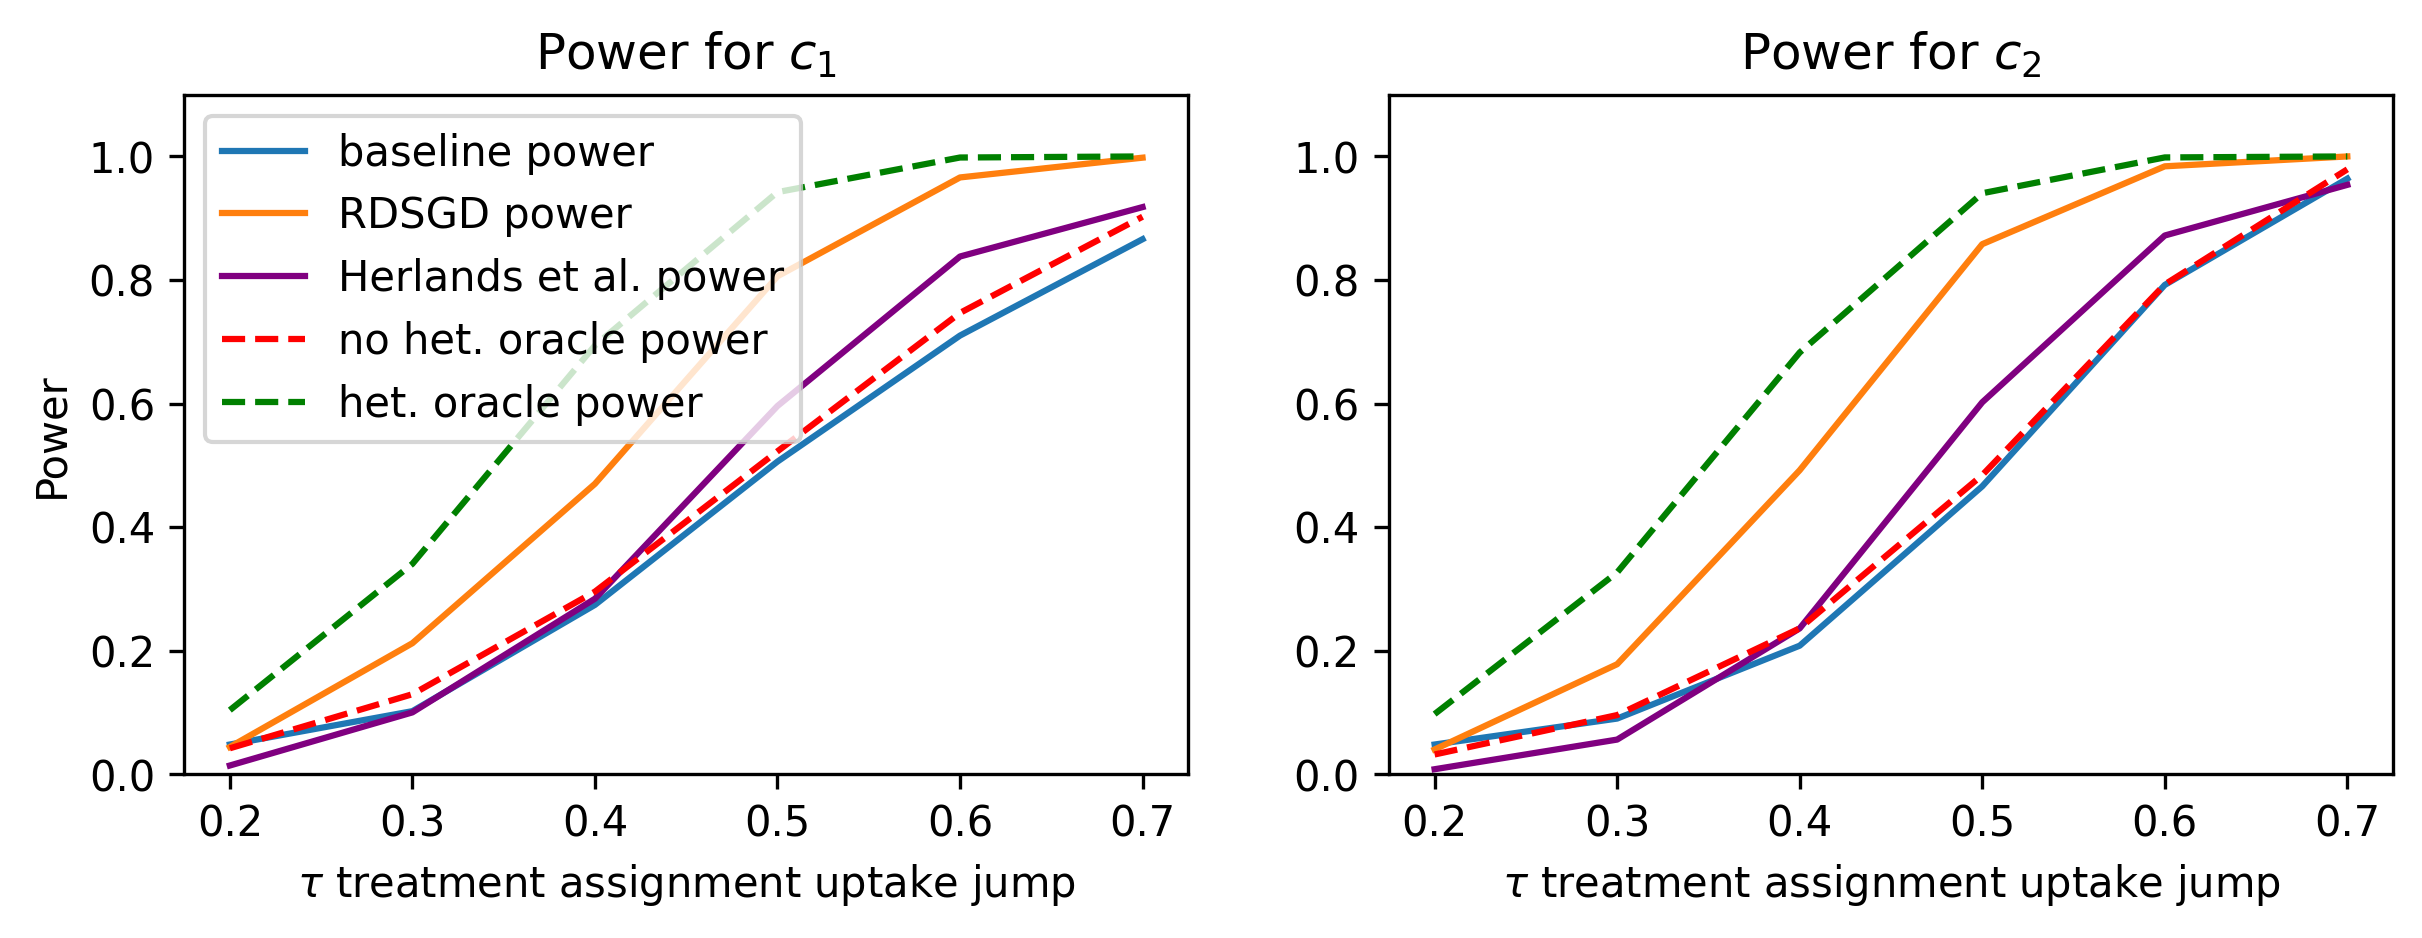

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, dpi=300, figsize=(9.5,3))
fig.patch.set_facecolor('white')

ax1.plot(fuzzy_gaps, lower_emp_fs_pwr, label="baseline power")
ax1.plot(fuzzy_gaps, lower_emp_pt_pwr, label="RDSGD power")
ax1.plot(fuzzy_gaps, lower_emp_herlands_pwr, color='purple', label="Herlands et al. power")

ax1.plot(fuzzy_gaps, lower_powers, ls='--', color='red', label="no het. oracle power")
ax1.plot(fuzzy_gaps, lower_max_powers, ls='--', color='green', label="het. oracle power")

ax2.plot(fuzzy_gaps, upper_emp_fs_pwr)
ax2.plot(fuzzy_gaps, upper_emp_pt_pwr)
ax2.plot(fuzzy_gaps, upper_emp_herlands_pwr, color='purple', label="empirical power, Herlands et al.")

ax2.plot(fuzzy_gaps, upper_powers, ls='--', color='red', label='theoretical power')
ax2.plot(fuzzy_gaps, upper_max_powers, ls='--', color='green', label="theoretical max power")


ax1.legend()

ax1.set_ylim(0, 1.1)
ax2.set_ylim(0, 1.1)
ax1.set_title("Power for $c_1$")
ax2.set_title("Power for $c_2$")
ax1.set_xlabel("$\\tau$ treatment assignment uptake jump")
ax2.set_xlabel("$\\tau$ treatment assignment uptake jump")
ax1.set_ylabel("Power")
fig.patch.set_facecolor('white')
#fig.suptitle("Power calculation for blended RDD discovery, n=1000, 500 trials, alpha=0.05")
fig.savefig(os.path.join(FIG_DIR, "blended_rdd_pwr.png"), bbox_inches='tight')

## False positive results

In [19]:
x_pt_fps = [rdsgd_results[gap]['fp'] / rdsgd_results[gap]['tot_tests'] for gap in fuzzy_gaps]


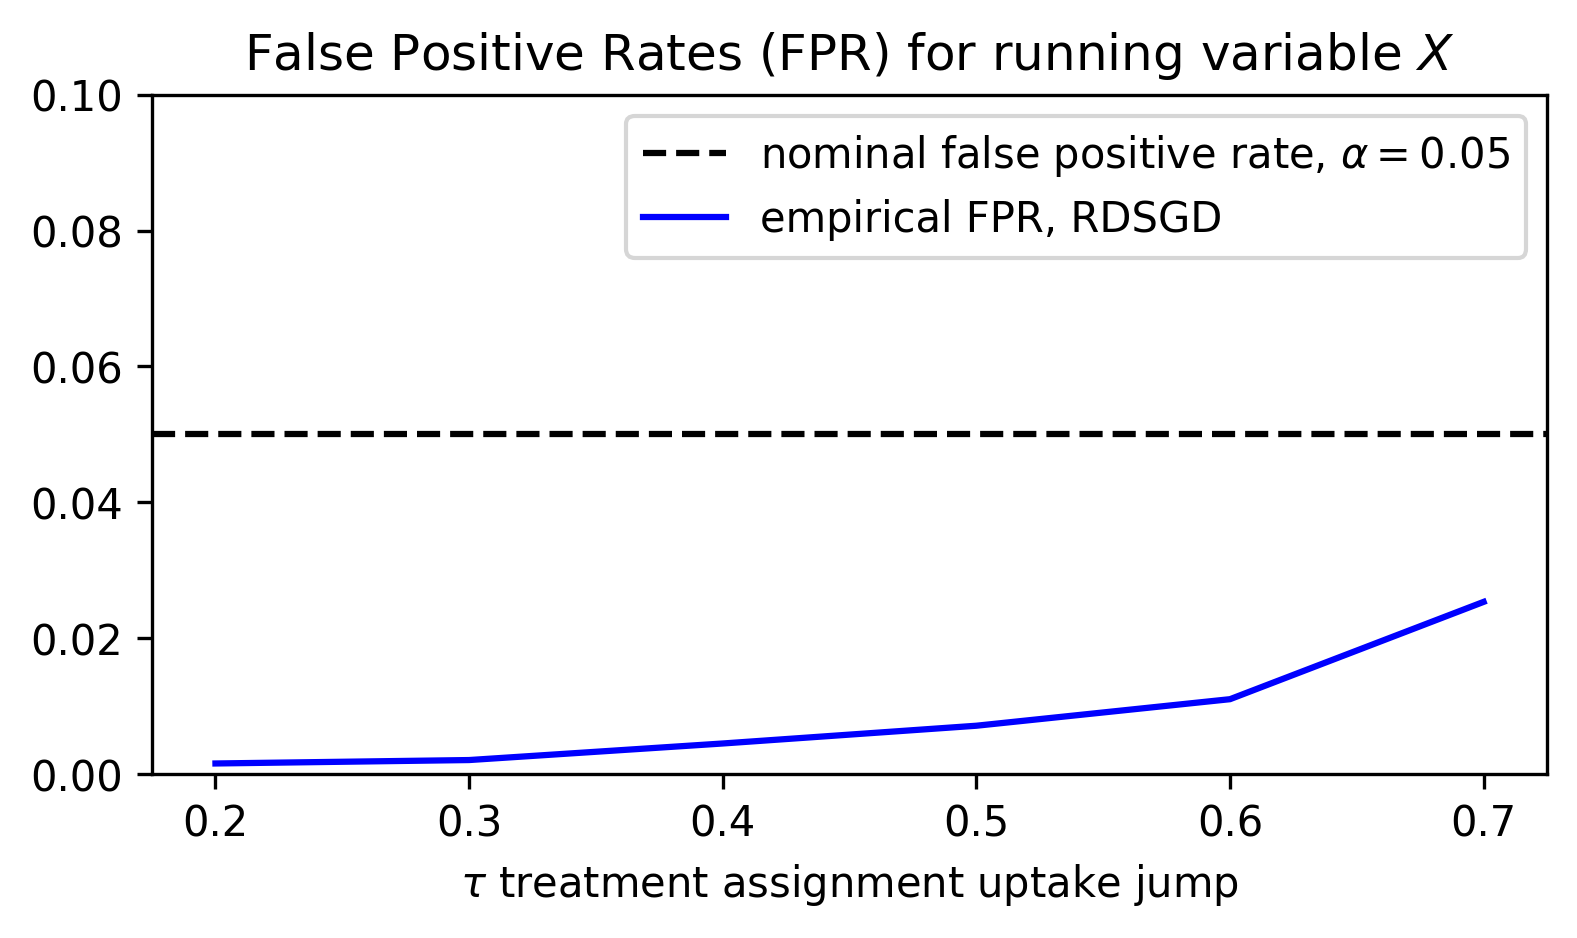

In [20]:
fig, ax = plt.subplots(dpi=300, figsize=(6,3))

#ax.plot(fuzzy_gaps, x_fs_fps, color='blue', label='empirical FPR, baseline')
ax.axhline(y=0.05, ls='--', color='black', label="nominal false positive rate, $\\alpha=0.05$")
ax.plot(fuzzy_gaps, x_pt_fps, color='blue', label='empirical FPR, RDSGD')
ax.legend()

ax.set_ylim(0, 0.1)
ax.set_title("False Positive Rates (FPR) for running variable $X$")
ax.set_xlabel("$\\tau$ treatment assignment uptake jump")
fig.patch.set_facecolor('white')
fig.savefig(os.path.join(FIG_DIR, "blended_fpr.png"), bbox_inches='tight')

In [21]:
first_stage_results

{0.2: {'x': {'fp': 47, 'lower_fn': 476, 'upper_fn': 476}, 'covar': {'fp': 69}},
 0.3: {'x': {'fp': 56, 'lower_fn': 449, 'upper_fn': 455},
  'covar': {'fp': 107}},
 0.4: {'x': {'fp': 81, 'lower_fn': 363, 'upper_fn': 396},
  'covar': {'fp': 192}},
 0.5: {'x': {'fp': 109, 'lower_fn': 247, 'upper_fn': 267},
  'covar': {'fp': 325}},
 0.6: {'x': {'fp': 159, 'lower_fn': 145, 'upper_fn': 104},
  'covar': {'fp': 429}},
 0.7: {'x': {'fp': 258, 'lower_fn': 67, 'upper_fn': 18}, 'covar': {'fp': 533}}}

# Chi-squared comparisons between empirical power

In [22]:
baseline_df = pd.DataFrame()

for gap in fuzzy_gaps:
    df = pd.DataFrame()
    df['upper_correct'] = [n_trials - first_stage_results[gap]['x']['upper_fn']]
    df['upper_incorrect'] = n_trials - df['upper_correct']
    df['lower_correct'] = n_trials - first_stage_results[gap]['x']['lower_fn']
    df['lower_incorrect'] = n_trials - df['lower_correct']
    df['gap'] = gap
    
    baseline_df = baseline_df.append(df)
    
baseline_df['is_subgroup'] = 0

In [23]:
herlands_df = pd.DataFrame()

for gap in fuzzy_gaps:
    df = pd.DataFrame()
    df['upper_correct'] = [herlands_results[gap]['upper_tp']]
    df['upper_incorrect'] = n_trials - df['upper_correct']
    df['lower_correct'] = herlands_results[gap]['lower_tp']
    df['lower_incorrect'] = n_trials - df['lower_correct']
    df['gap'] = gap
    
    herlands_df = herlands_df.append(df)
    
herlands_df['is_subgroup'] = 0

In [24]:
subgroup_df = pd.DataFrame()

for gap in fuzzy_gaps:
    df = pd.DataFrame()
    df['upper_correct'] = [rdsgd_results[gap]['upper_tp']]
    df['upper_incorrect'] = n_trials - df['upper_correct']
    df['lower_correct'] = rdsgd_results[gap]['lower_tp']
    df['lower_incorrect'] = n_trials - df['lower_correct']
    df['gap'] = gap
    
    
    subgroup_df = subgroup_df.append(df)
    
subgroup_df['is_subgroup'] = 1

In [25]:
# swap with baseline_df to compare to baseline
chi2_df = herlands_df.append(subgroup_df)

In [26]:
for gap in fuzzy_gaps:
    print(gap)
    sel_df = chi2_df[chi2_df['gap'] == gap]
    
    upper_tab = sel_df[["upper_correct", "upper_incorrect"]]
    lower_tab = sel_df[["lower_correct", "lower_incorrect"]]

    
    # low frequency counts for 0.2, 0.7, 0.8
    if gap in [0.2, 0.7, 0.8]:
        test_func = fisher_exact

    else:
        test_func = chi2_contingency

    _, u_pval, *_ = test_func(upper_tab)
    _, l_pval, *_ = test_func(lower_tab)  
    print("upper cutoff p-val: {:.3f}".format(u_pval))
    print("lower cutoff p-val: {:.3f}".format(l_pval))

0.2
upper cutoff p-val: 0.001
lower cutoff p-val: 0.007
0.3
upper cutoff p-val: 0.000
lower cutoff p-val: 0.000
0.4
upper cutoff p-val: 0.000
lower cutoff p-val: 0.000
0.5
upper cutoff p-val: 0.000
lower cutoff p-val: 0.000
0.6
upper cutoff p-val: 0.000
lower cutoff p-val: 0.000
0.7
upper cutoff p-val: 0.000
lower cutoff p-val: 0.000
